In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import pandas as pd
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
from sklearn.model_selection import train_test_split



In [2]:
"""
#load the image arrays 

blends = np.load("central_blends.npy")
components = np.load("central_components.npy")
"""

'\n#load the image arrays \n\nblends = np.load("C:\\Datasets\\central_blends.npy")\ncomponents = np.load("C:\\Datasets\\central_components.npy")\n'

In [3]:

#load the image arrays 

blends = np.load("blends.npy")
components = np.load("components.npy")


In [4]:

#Normalise the data

blends_max = np.amax(blends)
blends_min = np.amin(blends)

blends -= blends_min
blends /= blends_max

components_max = np.amax(components) 
components_min = np.amin(components)

components -= components_min
components /= components_max 



In [5]:
height,width=64,64

n_gals = blends.shape[0] 

blends = blends.reshape(n_gals, height, width, 1).astype('float32')
components= components.reshape(2,n_gals,height,width,1).astype('float32')


In [6]:
batch_size = 32
latent_dimensions = 32

In [7]:
blends.shape, components.shape

((30000, 64, 64, 1), (2, 30000, 64, 64, 1))

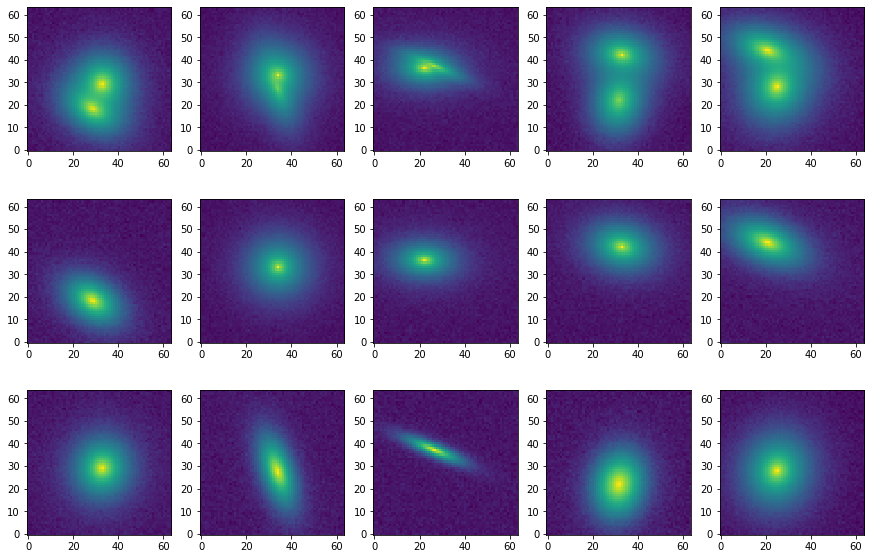

In [8]:
fig, ax = plt.subplots(2 + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(blends[i], origin='lower', interpolation='nearest')
    ax[1, i].imshow(components[0, i], origin='lower', interpolation='nearest')
    ax[2, i].imshow(components[1, i], origin='lower', interpolation='nearest')

In [9]:
#Will optimise encoder / decoder later
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    return x

In [10]:
def decoder(x):
    #x=UpSampling2D()(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [11]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [12]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [13]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [14]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d_1[0][0]']               
                                                                                              

In [15]:
input_component1 = Input(shape=(height, width, 1))
input_component2 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1, input_component2], [output1, output2])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 1024)         33792       ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1024)         33792       ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 4, 4, 64)     0           ['dense_2[0][0]']                
                                                                                            

In [16]:
encoding = encode(input_blend)
re1, re2 = decode([encoding, input_component1, input_component2])

vae = Model([input_blend, input_component1, input_component2], [re1, re2])

In [17]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           130592      ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                            

In [18]:
blends.shape, components.shape 

((30000, 64, 64, 1), (2, 30000, 64, 64, 1))

In [19]:
mse_lossA = mse(input_component1, re1) + mse(input_component2, re2)
mse_lossA = tf.reduce_mean(mse_lossA / 2, axis=(1, 2))
mse_lossB = mse(input_component1, re2) + mse(input_component2, re1)
mse_lossB = tf.reduce_mean(mse_lossB / 2, axis=(1, 2))
mse_loss = tf.reduce_mean(tf.minimum(mse_lossA, mse_lossB)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.1
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')


together = [blends, components[0], components[1]]
vae.compile(optimizer=Adam())

In [20]:
history=vae.fit(together, verbose = 1, epochs = 1, batch_size = batch_size, validation_split = 0.2)

750/750 [==============================] - 175s 230ms/step - loss: 12.4411 - mse_loss: 12.2014 - kl_loss: 0.2397 - val_loss: 7.2692 - val_mse_loss: 7.0100 - val_kl_loss: 0.2592


In [21]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

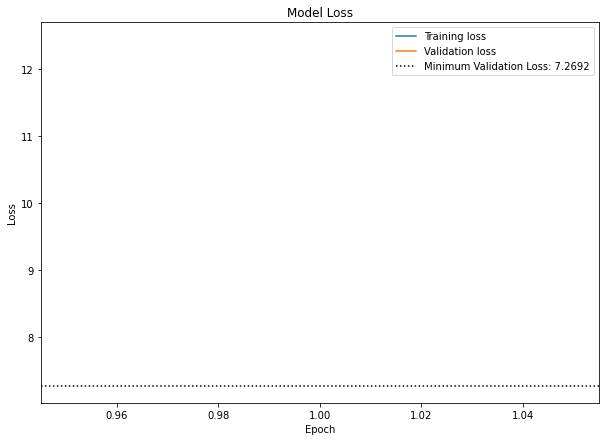

In [22]:
histplot(history)

In [46]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    fig, ax = plt.subplots(7, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest')
        ax[0, i].set_title('Input Blend')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest')
        ax[1, i].set_title('Input Component 1')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest')
        ax[2, i].set_title('Input Component 2')
        ax[3, i].imshow(output_img1[i], origin='lower', interpolation='nearest')
        ax[3, i].set_title('Reconstruction Component 1')
        ax[3, i].set_xlabel(f'MSE: {mean_squared_error(comp1[i], output_img1[i]):.2f}, SSIM: {ssim(comp1[i], output_img1[i], channel_axis = 2):.2f}')
        ax[4, i].imshow(output_img2[i], origin='lower', interpolation='nearest')
        ax[4, i].set_title('Reconstruction Component 2')
        ax[5, i].imshow((output_img1[i] + output_img2[i]) , origin='lower', interpolation='nearest')
        ax[5, i].set_title('Reconstruction Blend')
        ax[4, i].set_xlabel(f'MSE: {mean_squared_error(comp2[i], output_img2[i]):.2f}, SSIM: {ssim(comp2[i], output_img2[i], channel_axis = 2):.2f}')
        ax[6, i].imshow(-1*abs(input_img[i] -(output_img1[i] + output_img2[i])) , origin='lower', interpolation='nearest')
        ax[6, i].set_title('Blend Difference')
        plt.tight_layout()
    return idx

[10747 12573 29676  8856 21098]


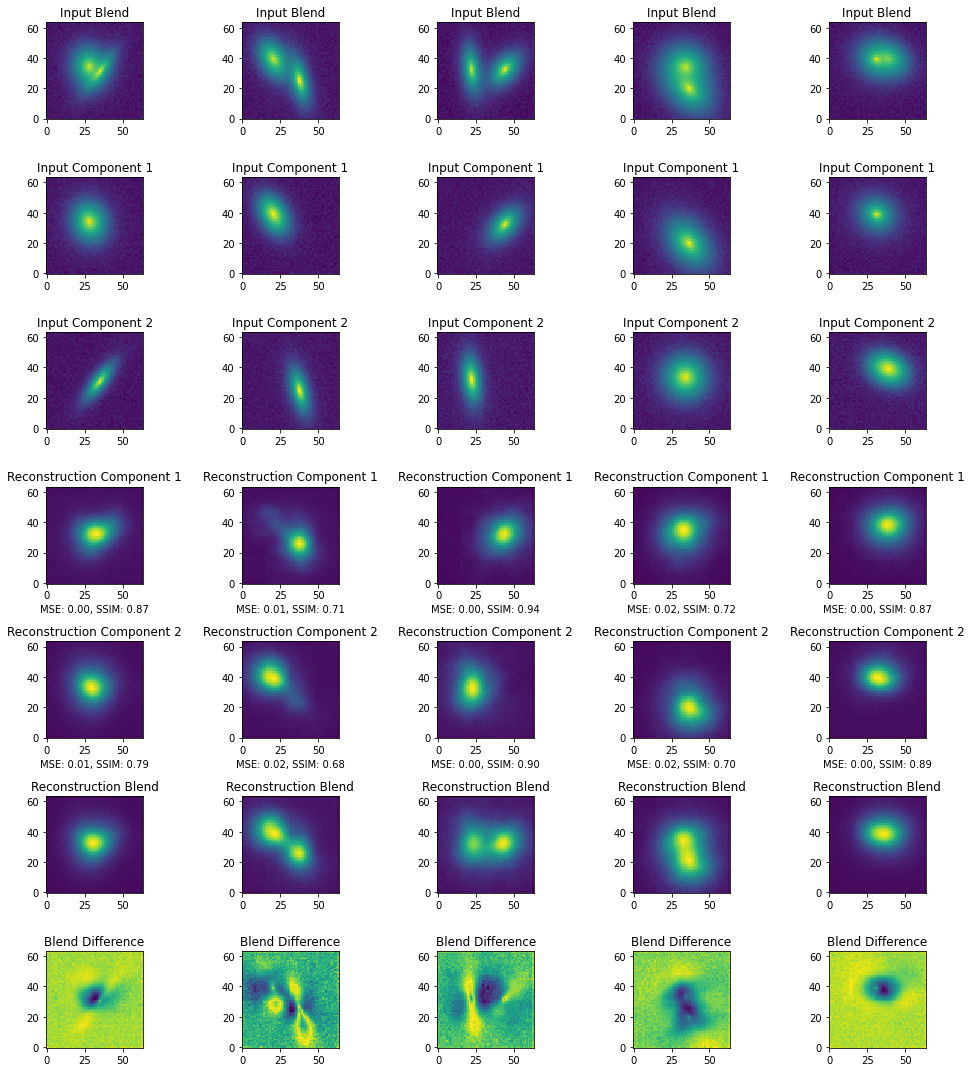

In [47]:
n=5
chosen=summary_plot(n,together,decode)

In [48]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(n_gals)
    ssim_comp2 = ssim_comp1
    ssim_blends = ssim_comp1
    input_img = inputs[0]
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    for i in range(n_gals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis = 2)
        ssim_comp2[i] = ssim(comp2[i], output_img2[i], channel_axis = 2)
        ssim_blends[i] = ssim(input_img[i], (output_img1[i] + output_img2[i]), channel_axis = 2)
    mean_ssim_comp1 = np.mean(ssim_comp1)
    median_ssim_comp1 = np.median(ssim_comp1)
    
    mean_ssim_comp2 = np.mean(ssim_comp2)
    median_ssim_comp2 = np.median(ssim_comp2)
    
    mean_ssim_blends = np.mean(ssim_blends)
    median_ssim_blends = np.median(ssim_blends)
    
    ssim_values = np.array([mean_ssim_comp1, median_ssim_comp1, mean_ssim_comp2, median_ssim_comp2, mean_ssim_blends, median_ssim_blends])
    
    return ssim_values 
        
        
        

    
    

In [49]:
ssim_values = calc_ssim(together, decode)


In [50]:
mean_ssim_comp1 = ssim_values[0]
median_ssim_comp1 = ssim_values[1]
mean_ssim_comp2 = ssim_values[2]
median_ssim_comp2 = ssim_values[3]
mean_ssim_blends = ssim_values[4]
median_ssim_blends = ssim_values[5]

In [51]:
print(f' Mean SSIMs: Component 1: {mean_ssim_comp1:.4f}, Component 2: {mean_ssim_comp2:.4f}, Blends: {mean_ssim_blends:.4f}')

print(f' Median SSIMs: Component 1: {median_ssim_comp1:.4f}, Component 2: {median_ssim_comp2:.4f}, Blends: {median_ssim_blends:.4f}')


 Mean SSIMs: Component 1: 0.8319, Component 2: 0.8319, Blends: 0.8319
 Median SSIMs: Component 1: 0.8402, Component 2: 0.8402, Blends: 0.8402


In [28]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(n_gals)
    
    flux_in_comp1 = np.zeros(n_gals)
    flux_in_comp2 = np.zeros(n_gals)
    flux_in_blends = np.zeros(n_gals)
    
    flux_out_comp1 = np.zeros(n_gals)
    flux_out_comp2 = np.zeros(n_gals)
    flux_out_blends = np.zeros(n_gals)
    
    
    elip_in_comp1 = np.zeros(n_gals)
    elip_in_comp2 = np.zeros(n_gals)
    
    elip_out_comp1 = np.zeros(n_gals)
    elip_out_comp2 = np.zeros(n_gals)
    
    input_img = inputs[0]
    input_img = input_img.reshape(n_gals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(n_gals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(n_gals, height,width)
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    
    output_img1 = output_img1.reshape(n_gals, height, width)
    output_img2 = output_img2.reshape(n_gals, height, width)
    
    for i in range(n_gals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
  
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
        
        in_blends_cat = photutils.morphology.data_properties(input_img[i], mask = None, background = 0)
        flux_in_blends[i] = in_blends_cat.segment_flux

            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        out_comp2_cat = photutils.morphology.data_properties(output_img2[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        out_blends_cat = photutils.morphology.data_properties((output_img1[i] + output_img2[i]), mask = None, background = 0)
        flux_out_blends[i] = out_blends_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2, flux_in_blends, flux_out_blends]   
    return parameters


        

In [29]:
parameters = calc_properties(together, decode)

In [30]:
from scipy.stats import gaussian_kde

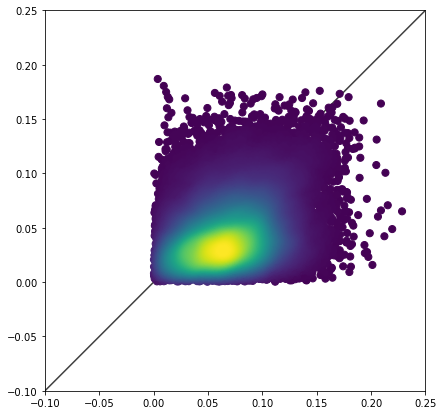

In [53]:
# Calculate the point density
x = parameters[0]
y = parameters[1]

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
ax.set_xlim([-0.1,0.25])
ax.set_ylim([-0.1,0.25])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()

In [32]:
elip_in_comp1 = parameters[0]
elip_out_comp1 = parameters[1]

elip_comp1_diff = (elip_in_comp1 - elip_out_comp1) 

print(elip_comp1_diff)

[ 0.02225543 -0.00708741  0.05994252 ... -0.06732416 -0.01117961
  0.00883411]


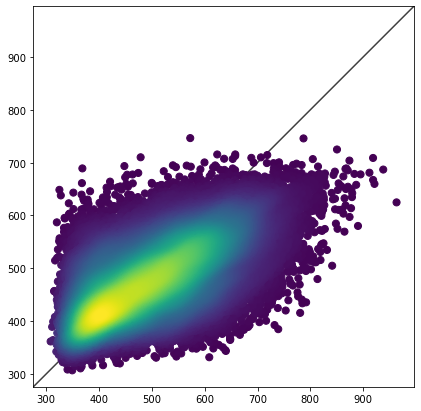

In [33]:
# Calculate the point density
x = parameters[2]
y = parameters[3]

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
#ax.set_xlim([-1,1])
#ax.set_ylim([-1,1])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()

In [34]:
# 1) I decided that an obvious metric to test would be to see the % accuracy of the ellipticity and the flux 

# i.e abs ( Difference / input_value ) * 100

# At the moment I will get the abs value as I dont want the fact that if the network has a normal distribution of over or 
# underestimating the flux/ellipticity the accuracy will be overestimated 


elip_comp1_accuracy = (abs(parameters[0] - parameters[1] ) / parameters[0]) * 100
mean_elip_comp1_accuracy = np.mean(elip_comp1_accuracy)
median_elip_comp1_accuracy = np.median(elip_comp1_accuracy)


flux_comp1_accuracy = (abs(parameters[2] - parameters[3]) / parameters[2]) * 100
mean_flux_comp1_accuracy = np.mean(flux_comp1_accuracy)
median_flux_comp1_accuracy = np.median(flux_comp1_accuracy)

elip_comp2_accuracy = (abs(parameters[4] - parameters[5]) / parameters[4]) * 100 
mean_elip_comp2_accuracy = np.mean(elip_comp2_accuracy)
median_elip_comp2_accuracy = np.median(elip_comp2_accuracy)


flux_comp2_accuracy = (abs(parameters[6] - parameters[7]) / parameters[6]) * 100
mean_flux_comp2_accuracy = np.mean(flux_comp2_accuracy)
median_flux_comp2_accuracy = np.median(flux_comp2_accuracy)

flux_blend_accuracy = (abs(parameters[8] / parameters[9]) / parameters[8]) * 100 
mean_flux_blend_accuracy = np.mean(flux_blend_accuracy)
median_flux_blend_accuracy = np.median(flux_blend_accuracy)








In [35]:
print(f' Mean ellipticity accuracys: Component 1: {mean_elip_comp1_accuracy :.4f}, Component 2: {mean_elip_comp2_accuracy:.4f}')
print(f' Median ellipticity accuracys: Component 1: {median_elip_comp1_accuracy:.4f}, Component 2: {median_elip_comp2_accuracy:.4f}')

 Mean ellipticity accuracys: Component 1: 66.7047, Component 2: 66.8300
 Median ellipticity accuracys: Component 1: 49.5356, Component 2: 48.7863


In [36]:
print(f' Mean flux accuracys: Component 1: {mean_flux_comp1_accuracy:.4f}, Component 2: {mean_flux_comp2_accuracy:.4f}, Blends: {mean_flux_blend_accuracy:.4f}')
print(f' Median flux accuracys: Component 1: {median_flux_comp1_accuracy:.4f}, Component 2: {median_flux_comp2_accuracy:.4f}, Blends: {median_flux_blend_accuracy:.4f}')

 Mean flux accuracys: Component 1: 13.1319, Component 2: 13.6317, Blends: 0.1014
 Median flux accuracys: Component 1: 10.9538, Component 2: 10.4995, Blends: 0.1005


In [37]:
# I THINK THERE IS A PROBLEM WITH JUST ADDING THE ARRAY VALUES WHEN YOU CALCULATE THE BLENDS 


# AS YOU CAN SEE THE BLEND ACCURACY IS TERRIBLE !!!!
# I NEED TO SPEAK TO BAMFORD ABOUT THIS 


In [38]:
# 2) I also thought it was a bit weird that the highest ellipticity is 0.2 when you check the code that makes the blends it is a uniform distribution between 0 and 0.8

# TURN TO MY BLENDS CODE IM GOING TO PRINT ELLIPTICITY DISTRIBUTION AND THEN PRINT WHAT THE PHOT UTILS PRINTS AND SEE IF THERE IS A DIFFERENCE



In [39]:




#3) The plots are ugly I want to improve them 



